This notebook is aimed to examine the sensitivity of peak water to initial thickness (therefor initial volume)

# Option 1

In this workflow, the intend is to calibrate the glen parameter A to be the closest from the one of the consensus or of Millan observations.

In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as colormap
from oggm import cfg, utils, workflow, tasks, graphics,core
import pandas as pd
import numpy as np
from oggm.shop import bedtopo,gcm_climate
import salem

import add_data
import work_tasks
import graph

cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] =  '/home/lucillegimenes/oggm-workflow-b/'
cfg.PARAMS['use_multiprocessing']=True
#cfg.PARAMS['store_fl_diagnostics'] = True
cfg.PARAMS['store_model_geometry'] = True


utils.get_rgi_dir(version='62')

rgi_ids = ['RGI60-13.37753'] 

# The RGI version to use
# Size of the map around the glacier.
prepro_border = 80
# Degree of processing level. This is OGGM specific and for the shop 1 is the one you want
from_prepro_level = 3
# URL of the preprocessed gdirs
#base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/no_match/'
base_url='https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/elev_bands/qc3/pcp2.5/match_geod/'

2021-12-09 09:57:38: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-12-09 09:57:38: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-12-09 09:57:38: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-12-09 09:57:38: oggm.cfg: Multiprocessing switched ON after user settings.
2021-12-09 09:57:38: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


# 1. Running simulations based on the calibration

In [2]:
cfg.add_to_basenames('model_geometry_my_spinup','model_geometry_my_spinup.nc')
cfg.add_to_basenames('model_geometry_with_spinup','model_geometry_with_spinup.nc')
for rcp in ['rcp26','rcp45','rcp60','rcp85']:
    cfg.add_to_basenames('model_geometry_CCSM4_'+rcp+'','model_geometry_CCSM4_'+rcp+'.nc')
    cfg.add_to_basenames('model_diagnostics_CCSM4_'+rcp+'','model_diagnostics_CCSM4_'+rcp+'.nc')

In [3]:
for ssp in ['ssp126','ssp534-over','ssp585']:
    cfg.add_to_basenames('model_geometry_MRI-ESM2-0_'+ssp+'','model_geometry_MRI-ESM2-0_'+ssp+'.nc')
    cfg.add_to_basenames('model_diagnostics_MRI-ESM2-0_'+ssp+'','model_diagnostics_MRI-ESM2-0_'+ssp+'.nc')

In [4]:
cfg.add_to_basenames('model_geometry_no_spinup','model_geometry_no_spinup.nc')

In [5]:
cfg.add_to_basenames('gcm_data_CCSM4_rcp26','gcm_data_CCSM4_rcp26.nc')
cfg.add_to_basenames('gcm_data_CCSM4_rcp85','gcm_data_CCSM4_rcp85.nc')

In [6]:
#download and process gcmbdata with SSP

bp_s='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/MRI-ESM2-0/MRI-ESM2-0_{}_r1i1p1f1_pr.nc'
bt_s='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/MRI-ESM2-0/MRI-ESM2-0_{}_r1i1p1f1_tas.nc'

In [7]:
vol_f=[0.1,0.3,0.5,0.6,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.8,2]

In [8]:
for f in range(0,len(vol_f)):
    cfg.add_to_basenames('model_geometry_with_spinup_{}'.format(f),'model_geometry_with_spinup_{}.nc'.format(f))
    cfg.add_to_basenames('model_geometry_MRI-ESM2-0_ssp126_{}'.format(f),'model_geometry_MRI-ESM2-0_ssp126_{}.nc'.format(f))

In [174]:
import work_tasks
from oggm.core import climate, massbalance, flowline

import time
# start time !
start_time = time.time()

temp_bias=vol_f


#Pre-allocate'0':[0]*3

out_evol={'0':[0]*3,'1':[0]*3,'2':[0]*3,'3':[0]*3,'4':[0]*3,'5':[0]*3,'6':[0]*3,'7':[0]*3,
         '8':[0]*3,'9':[0]*3,'10':[0]*3,'11':[0]*3,'12':[0]*3,'13':[0]*3}

out_hydro_hist = [0]*len(vol_f)
list_out_surf=[0]*len(vol_f)
list_out_bed=[0]*len(vol_f)
list_out_surf_evol=[0]*len(vol_f)
list_out_bed_evol=[0]*len(vol_f)
list_out_surf_evol_ex=[0]*len(vol_f)
d_=[0,0,0]

#Calibration parameters
#bounds=(0.1,10)
bounds=(0.005,10)
#path_to_hdf='/home/lucillegimenes/volumes_millan_2000.h5'
path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set_2000.h5'
#path_to_hdf='/home/lucillegimenes/volumes_millan_13_spe_set.h5

data_list=['farinotti'] #options : 'farinotti', 'millan'
for data in data_list:
       for f in range(0,len(vol_f)):
            gdirs = workflow.init_glacier_directories(rgi_ids,from_prepro_level=from_prepro_level,prepro_border=80)
            gdir=gdirs[0]

            gdir.name_corr=gdir.name.replace('/','-')
            if (gdir.name==''):
                gdir.name_corr='Aletsch'
        
            #Little adjustment
            if (gdir.rgi_region in ['13','14','15']):
                gdir.rgi_region_m='13-15'
            else:
                gdir.rgi_region_m=gdir.rgi_region
        
            if (data=='farinotti'):
                work_tasks.calibrate_inversion_from_consensus(gdir,vol_bias=vol_f[f],apply_fs_on_mismatch=True,error_on_mismatch=False)
                workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)
            elif(data=='millan'):
                work_tasks.calibrate_inversion_from_millan(gdir,path_to_hdf,vol_bias=vol_f[f],apply_fs_on_mismatch=True,error_on_mismatch=False,
                                                       a_bounds=bounds)
            workflow.execute_entity_task(tasks.init_present_time_glacier, gdir)

            #Run the spinup simulation - t* climate    
            workflow.execute_entity_task(tasks.run_constant_climate, gdir,nyears=200,output_filesuffix='_my_spinup_{}'.format(f)) 


                # Run a past climate run based on this spinup
            workflow.execute_entity_task(tasks.run_with_hydro, gdir, run_task=tasks.run_from_climate_data,
                                            climate_filename='climate_historical', init_model_filesuffix='_my_spinup_{}'.format(f),
                                            ys=2003,ye=2020,
                                            output_filesuffix='_with_spinup_{}'.format(f),store_monthly_hydro=True)

            with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix='_with_spinup_{}'.format(f))) as dh:
                dh = dh.load()

            out_hydro_hist[f]=dh


            
        #For plotting the initial profile
            fmod = flowline.FileModel(gdir.get_filepath('model_geometry_with_spinup_{}'.format(f)))
            fl = fmod.fls[-1]  # Main flowline
            i, j = fl.line.xy  # xy flowline on grid
            lons, lats = gdir.grid.ij_to_crs(i, j, crs='EPSG:4326')  # to WGS84

            df_coords = pd.DataFrame(index=fl.dis_on_line*gdir.grid.dx)
            df_coords.index.name = 'Distance along flowline'
            df_coords['lon'] = lons
            df_coords['lat'] = lats
            df_coords['bed_elevation'] = fl.bed_h

            df_thick = pd.DataFrame(index=df_coords.index)
            df_surf_h = pd.DataFrame(index=df_coords.index)
            df_bed_h = pd.DataFrame()

            for year in range(2003, 2005):
                fmod.run_until(year)
                fl = fmod.fls[-1]
                df_thick[year] = fl.thick
                df_surf_h[year] = fl.surface_h

            list_out_surf[f]= df_surf_h[[2003]]
            list_out_bed[f]=df_coords['bed_elevation']
            
            
        

            for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
            # read the path to the files, not opening with xr.opendataset()
                ft = utils.file_downloader(bt_s.format(ssp))
                fp = utils.file_downloader(bp_s.format(ssp))

            # bias correct them
                workflow.execute_entity_task(gcm_climate.process_cmip_data, gdir, filesuffix='_MRI-ESM2-0_{}_{}'.format(ssp,f),             # recognize the climate file for later
                                             fpath_temp=ft,                                  # temperature projections
                                             fpath_precip=fp,                                # precip projections
                                             );  


        #projection run (starting from the end year of the historical run)
            for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
                sid = '_MRI-ESM2-0_{}_{}'.format(ssp,f)
            # with hydro                                
                workflow.execute_entity_task(tasks.run_with_hydro, gdir, ys=2020,run_task=tasks.run_from_climate_data,
                                             climate_filename='gcm_data',             # use gcm_data, not climate_historical
                                             climate_input_filesuffix=sid,        # use the chosen scenario
                                             init_model_filesuffix='_with_spinup_{}'.format(f),             # this is important! Start from 2020 glacier
                                             output_filesuffix=sid,                          # recognize the run for later
                                             store_monthly_hydro=True,
                                            );

            # end of the run                                  
            print('Simulation finished sucessfully')
        
        
            #For plotting the evolution of the profile
            fmod2 = flowline.FileModel(gdir.get_filepath('model_geometry_MRI-ESM2-0_ssp126_{}'.format(f)))
            fl2 = fmod2.fls[-1]  # Main flowline
            i2, j2 = fl2.line.xy  # xy flowline on grid
            lons2, lats2 = gdir.grid.ij_to_crs(i2, j2, crs='EPSG:4326')  # to WGS84


            df_coords2 = pd.DataFrame(index=fl2.dis_on_line*gdir.grid.dx)
            df_coords2.index.name = 'Distance along flowline'
            df_coords2['lon'] = lons2
            df_coords2['lat'] = lats2
            df_coords2['bed_elevation'] = fl2.bed_h

            df_thick2 = pd.DataFrame(index=df_coords2.index)
            df_surf_h2 = pd.DataFrame(index=df_coords2.index)
            df_bed_h2 = pd.DataFrame()

            for year in range(2020, 2301):
                fmod2.run_until(year)
                fl2 = fmod2.fls[-1]
                df_thick2[year] = fl2.thick
                df_surf_h2[year] = fl2.surface_h

            list_out_surf_evol[f]= [df_surf_h2[[2020]],df_surf_h2[[2030]], df_surf_h2[[2040]],df_surf_h2[[2050]],
                                        df_surf_h2[[2060]],df_surf_h2[[2070]],df_surf_h2[[2080]],df_surf_h2[[2090]]]

            list_out_surf_evol_ex[f]= [df_surf_h2[[2100]],df_surf_h2[[2150]], df_surf_h2[[2200]],df_surf_h2[[2250]],
                                        df_surf_h2[[2300]]]
            list_out_bed_evol[f]=df_coords2['bed_elevation']


            r=0
            for ssp in ['ssp126', 'ssp534-over', 'ssp585']:
                sid = '_MRI-ESM2-0_{}_{}'.format(ssp,f)

                dsf = utils.compile_run_output(gdir, input_filesuffix=sid) 

                out_evol[str(f)][r]=dsf


                r+=1

    
print('Duration is')
print("--- %s seconds ---" % (time.time() - start_time)) 

2021-12-09 12:07:01: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-12-09 12:07:01: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2021-12-09 12:07:02: work_tasks: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-12-09 12:07:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-12-09 12:07:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2021-12-09 12:07:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2021-12-09 12:07:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2021-12-09 12:07:02: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2021-12-09 12:07:02: work_tasks: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-12-09 12:07:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-12-09 12:07:02: oggm.workflow: Execute entity tasks [prepar

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:08:04: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:08:04: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:08:04: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:08:04: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:08:05: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:09:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:09:17: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:09:17: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:09:17: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:09:17: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:10:24: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:10:24: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:10:24: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:10:24: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:10:24: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:11:26: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:11:26: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:11:26: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:11:26: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:11:26: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:12:29: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:12:29: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:12:29: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:12:29: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:12:29: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:13:33: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:13:33: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:13:33: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:13:33: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:13:33: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:14:40: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:14:40: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:14:40: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:14:40: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:14:41: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:15:43: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:15:43: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:15:43: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:15:43: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:15:43: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:16:46: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:16:46: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:16:46: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:16:46: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:16:46: oggm.utils: Applying global task

2021-12-09 12:17:00: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-12-09 12:17:02: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-12-09 12:17:04: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-12-09 12:17:21: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-12-09 12:17:33: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers


Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:17:51: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:17:51: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:17:51: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:17:51: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:17:51: oggm.utils: Applying global task

2021-12-09 12:18:03: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-12-09 12:18:06: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-12-09 12:18:10: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-12-09 12:18:24: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-12-09 12:18:38: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers


Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:18:54: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:18:54: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:18:54: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:18:54: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:18:54: oggm.utils: Applying global task

2021-12-09 12:19:06: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-12-09 12:19:10: oggm.workflow: Execute entity tasks [process_cmip_data] on 1 glaciers
2021-12-09 12:19:13: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-12-09 12:19:27: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers
2021-12-09 12:19:41: oggm.workflow: Execute entity tasks [run_with_hydro] on 1 glaciers


Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:19:58: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:19:58: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:19:59: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:19:59: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:19:59: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:21:03: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:21:03: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:21:03: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:21:03: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:21:03: oggm.utils: Applying global task

Simulation finished sucessfully


/tmp/ipykernel_6312/3724587310.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_thick2[year] = fl2.thick
/tmp/ipykernel_6312/3724587310.py:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_surf_h2[year] = fl2.surface_h
2021-12-09 12:22:05: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:22:05: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:22:05: oggm.utils: Applying global task compile_run_output on 1 glaciers
2021-12-09 12:22:05: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-12-09 12:22:05: oggm.utils: Applying global task

Duration is
--- 904.3693468570709 seconds ---


# 2. Figures

## Projected area evolution for several RCP scenarios

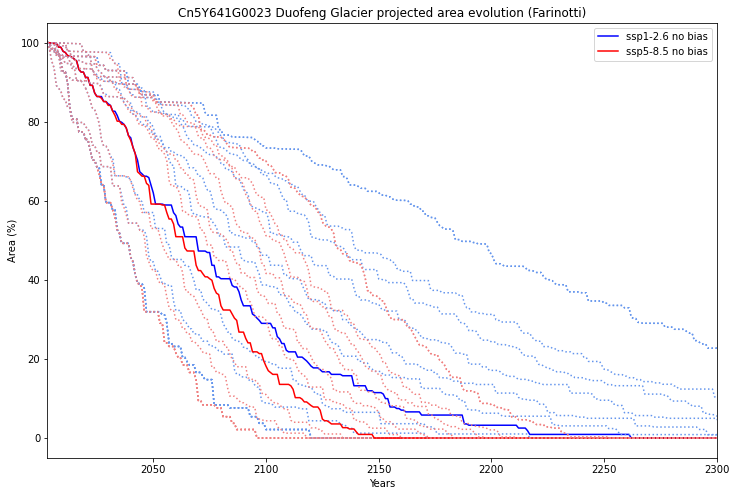

In [175]:
f, ax= plt.subplots(figsize=(12, 8))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']

for f in range(0,len(vol_f)):
        #(out_hydro_hist[f].area_m2*10**-6).plot(ax=ax,label=''+data+' historical', linestyle='-',color=color_s)
    start_a=np.float64(out_hydro_hist[f].area_m2.sel(time=[2003]))
    for k in range(0,3,2):
        if (k==0):

            if (f==6):
                color_s='b'
                st='-'
                label_s=''+ssp[k]+' no bias'
            else:
                color_s='cornflowerblue'
                st=':'
                label_s='_nolegend_'
        elif (k==2):
            if (f==6):
                color_s='r'
                st='-'
                label_s=''+ssp[k]+' no bias'
            else:
                st=':'
                color_s='lightcoral'
                label_s='_nolegend_'
                

        (out_hydro_hist[f].area_m2/start_a*100).plot(ax=ax,label='_nolegend_', linestyle=st,color=color_s)
        (out_evol[str(f)][k].area/start_a*100).plot(ax=ax,label=label_s, linestyle=st,color=color_s)


plt.legend()          
plt.title(''+gdir.name_corr+' projected area evolution (Farinotti)')
plt.xlabel('Years')
plt.xlim(2003,2300)
plt.ylabel('Area (%)')
name = ''+gdir.name_corr+'_area_%_f_sensi.png'
plt.savefig(name, format = 'png')

## Annual runoff and peak water 

In [11]:
spe_f=np.linspace(0,13,14,dtype=int)

In [12]:
spe_f=spe_f.tolist()
spe_f.pop(6)
spe_f.append(6)
spe_f

6

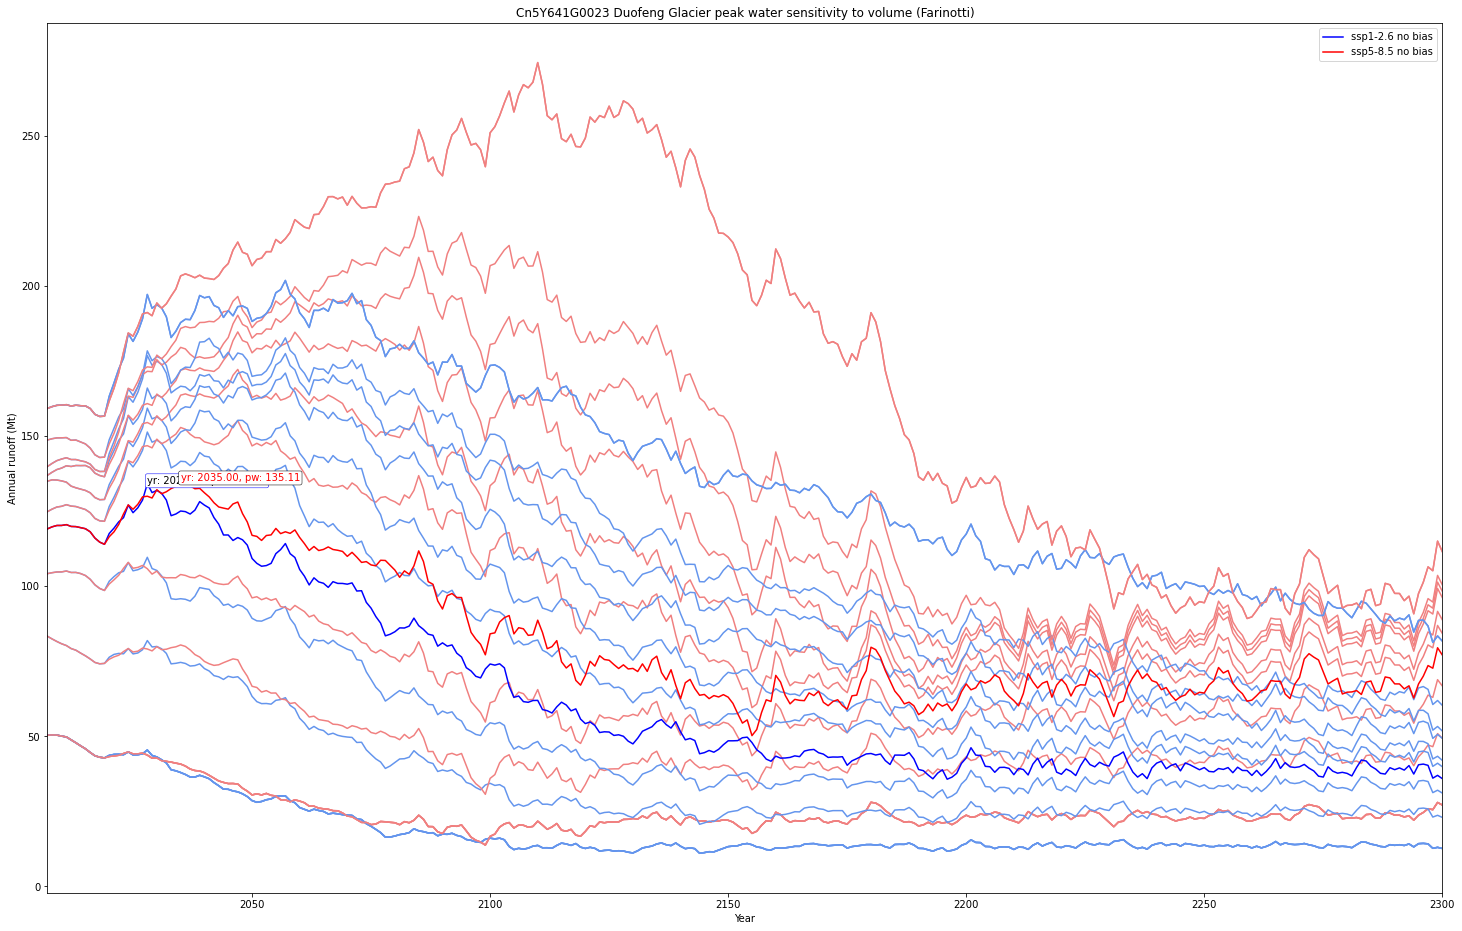

In [176]:
f, ax = plt.subplots(figsize=(25, 16))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']
m_yearpw={'ssp1-2.6':[0]*len(vol_f),'ssp5-8.5':[0]*len(vol_f)}
m_maxpw={'ssp1-2.6':[0]*len(vol_f),'ssp5-8.5':[0]*len(vol_f)}

for f in spe_f:
    
    for k in range(0,3,2): #loop all scenarios

        # Select annual variables
        d_p=out_evol[str(f)][k]
        d_h=out_hydro_hist[f]

        sel_vars = [v for v in d_p.variables if 'month_2d' not in d_p[v].dims]
        sel_vars_hist = [v for v in d_h.variables if 'month_2d' not in d_h[v].dims]
        
        # And create a dataframe
        dp_annual = d_p[sel_vars].to_dataframe()
        dh_annual = d_h[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.droplevel('rgi_id')  
        dp_runoff = dp_runoff.drop([2301],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dpt_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        # Sum the variables each year "axis=1", take the 11 year rolling mean
        # and plot it.
        year_pw=int(dpt_runoff.sum(axis=1).rolling(window=5).mean().idxmax())
        max_pw=dpt_runoff.sum(axis=1).rolling(window=5).mean().max()
        m_yearpw[ssp[k]][f]=year_pw
        m_maxpw[ssp[k]][f]=max_pw
        
        #Plotting styles
        
        if (k==0):
            st='-'

            if (f==6):
                color_s='b'
                plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color_s, lw=0.5))
                
                dpt_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax, label=''+ssp[k]+' no bias',linestyle=st,color=color_s)
            
            else:
                st='-'
                color_s='cornflowerblue'
                dpt_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax,label='_nolegend_', linestyle=st,color=color_s)
        if (k==1):
            st='dashed'
        elif(k==2):
            st='-'
            
            if (f==6):
                color_s='r'
                st='-'
                plt.text(year_pw, max_pw, 'yr: {:.2f}, '.format(year_pw)+'pw: {:.2f}'.format(max_pw),color=color_s,bbox=dict(boxstyle="round,pad=0.2", fc="white", ec='k', lw=0.5))
                dpt_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax, label=''+ssp[k]+' no bias',linestyle=st,color=color_s)
            else:
                color_s='lightcoral'
                dpt_runoff.sum(axis=1).rolling(window=5).mean().plot(ax=ax,label='_nolegend_', linestyle=st,color=color_s)
       
plt.xlim(2007,2300)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Year')
plt.title(''+gdir.name_corr+' peak water sensitivity to volume (Farinotti)')
plt.legend();
name = ''+gdir.name_corr+'_peak_water_vol_f'    
plt.savefig(name, format = 'png')

### Link between runoff and glacier area

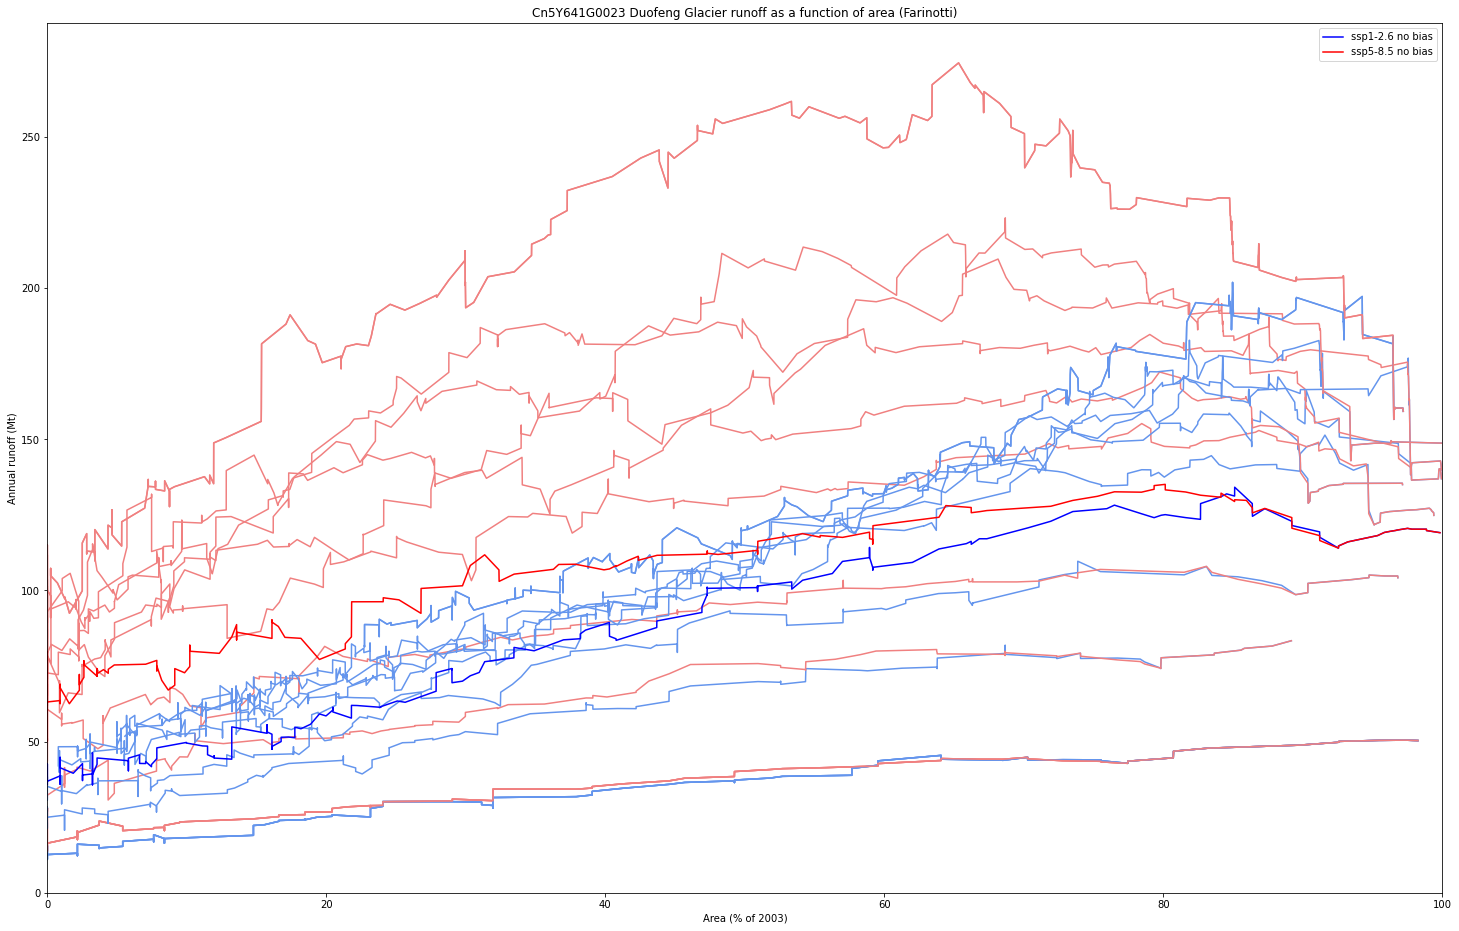

In [177]:
f, ax = plt.subplots(figsize=(25, 16))
ssp=['ssp1-2.6','ssp5-3.4','ssp5-8.5']

for f in spe_f:
    
    for k in range(0,3,2): #loop all scenarios

        # Select annual variables
        d_p=out_evol[str(f)][k]
        d_h=out_hydro_hist[f]

        sel_vars = [v for v in d_p.variables if 'month_2d' not in d_p[v].dims]
        sel_vars_hist = [v for v in d_h.variables if 'month_2d' not in d_h[v].dims]
        
        # And create a dataframe
        dp_annual = d_p[sel_vars].to_dataframe()
        dh_annual = d_h[sel_vars_hist].to_dataframe()

        # Select the variables relevant for runoff.
        runoff_vars = ['melt_off_glacier', 'melt_on_glacier','liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        
        dp_runoff = dp_annual[runoff_vars].clip(0) * 1e-9
        dp_runoff = dp_runoff.droplevel('rgi_id')  
        dp_runoff = dp_runoff.drop([2301],axis=0)
        
        dh_runoff = dh_annual[runoff_vars].clip(0) * 1e-9
        dh_runoff = dh_runoff.drop([2020],axis=0)
        
        
        dpt_runoff=pd.concat([dh_runoff,dp_runoff], axis=0)
        
        
        #Plotting styles
        
        
        
        start_a=np.float64(out_hydro_hist[f].area_m2.sel(time=[2003]))
        a_hist=np.array(out_hydro_hist[f].area_m2/start_a*100)
        a_evol=((out_evol[str(f)][k].area/start_a*100).to_series()).to_numpy()
        a_evol=a_evol[1:len(a_evol)-1]
        a_f=np.concatenate((a_hist,a_evol),axis=0)

        
        if (k==0):
            st='-'

            if (f==6):
                color_s='b'
                
                label_s=''+ssp[k]+' no bias'
            else:
                st='-'
                color_s='cornflowerblue'
                label_s='_nolegend_'
        if (k==1):
            st='dashed'
        elif(k==2):
            st='-'
            
            if (f==6):
                color_s='r'
                st='-'
                label_s=''+ssp[k]+' no bias'
                
            else:
                color_s='lightcoral'
                label_s='_nolegend_'
                
        plt.plot(a_f,dpt_runoff.sum(axis=1).rolling(window=5).mean(),label=label_s,color=color_s,linestyle=st)
    
       
plt.xlim([0,100])
plt.ylim(bottom=0)
ax.set_ylabel('Annual runoff (Mt)')
ax.set_xlabel('Area (% of 2003)')
plt.title(''+gdir.name_corr+' runoff as a function of area (Farinotti)')
plt.legend();
name = ''+gdir.name_corr+'_peak_water_area_vol_f'    
plt.savefig(name, format = 'png')

### Sensitivity of the peak water

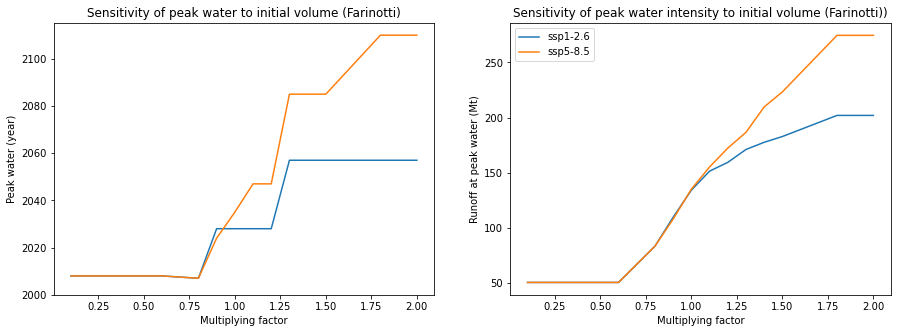

In [178]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(vol_f,m_yearpw['ssp1-2.6'],label='ssp1-2.6')
ax1.plot(vol_f,m_yearpw['ssp5-8.5'],label='ssp5-8.5')
plt.legend()
ax1.set_xlabel('Multiplying factor')
ax1.set_ylabel('Peak water (year)')
ax1.set_title('Sensitivity of peak water to initial volume (Farinotti)')
ax1.set_ylim(bottom=2000)

ax2.plot(vol_f,m_maxpw['ssp1-2.6'],label='ssp1-2.6')
ax2.plot(vol_f,m_maxpw['ssp5-8.5'],label='ssp5-8.5')
ax2.set_ylabel('Runoff at peak water (Mt)')
ax2.set_xlabel('Multiplying factor')
ax2.set_title('Sensitivity of peak water intensity to initial volume (Farinotti))')
plt.legend()
name = ''+gdir.name_corr+'_pw_panel_vol_f'    
plt.savefig(name, format = 'png')

## Plotting profiles

### Initial profil

/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f37946e26a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f3794a88940> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/lucillegimenes/miniconda3/envs/oggm_env/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f37a83fefd0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/home/lucillegimenes/miniconda3

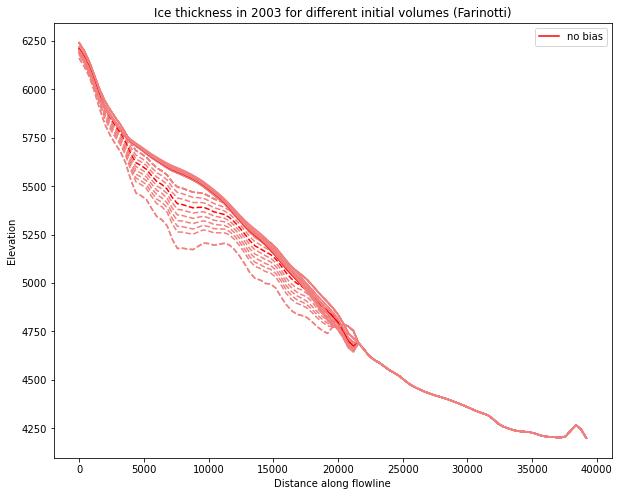

In [179]:
f, ax = plt.subplots(figsize=(10, 8))

for f in range(0,len(vol_f)):
    if (f==6):
        c='r'
        label_s='no bias'
    else:
        c='lightcoral'
        label_s='_nolegend_'
    d=list_out_surf[f].rename(columns={2003: label_s})
    d.plot(ax=ax,color=c)
    #plt.legend()
    list_out_bed[f].plot(ax=ax,ylabel='Elevation',style="--",color=c,label=label_s);
    #plt.legend()
plt.title('Ice thickness in 2003 for different initial volumes (Farinotti)');
name = ''+gdir.name_corr+'_profil_init_f_factvol.png'
plt.savefig(name, format = 'png')


### Profile in time 

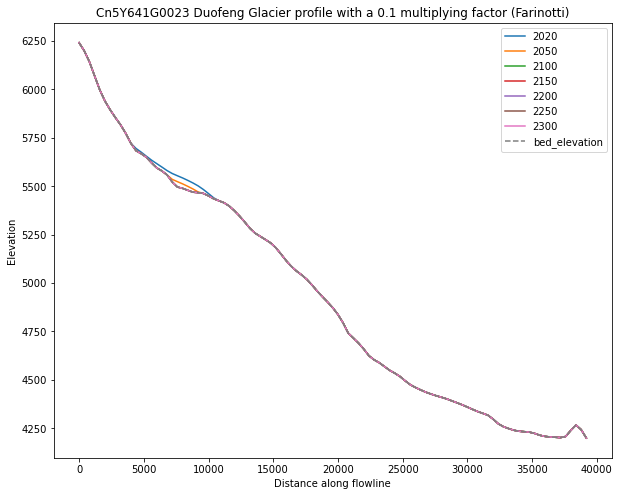

In [184]:
f, ax = plt.subplots(figsize=(10, 8))
i=0
df_surf_temoin=pd.concat([list_out_surf_evol[i][0],list_out_surf_evol[i][1],list_out_surf_evol[i][2],
                             list_out_surf_evol[i][3],list_out_surf_evol[i][4],list_out_surf_evol[i][5],
                             list_out_surf_evol[i][6],list_out_surf_evol[i][7]],axis=1)


df_surf_temoin_ex=pd.concat([list_out_surf_evol_ex[i][0],list_out_surf_evol_ex[i][1],list_out_surf_evol_ex[i][2],
                        list_out_surf_evol_ex[i][3],list_out_surf_evol_ex[i][4]], axis=1)
tot=pd.concat([df_surf_temoin,df_surf_temoin_ex],axis=1)
for year in [2020,2050,2100,2150,2200,2250,2300]:
    tot[[year]].plot(ax=ax);
    plt.legend()
list_out_bed_evol[i].plot(ax=ax,ylabel='Elevation',style="--");
plt.legend()
plt.title(''+gdir.name_corr+' profile with a '+str(vol_f[i])+' multiplying factor (Farinotti)');
name = ''+gdir.name_corr+'_profil_f_factvol_'+str(vol_f[i])+'.png'
plt.savefig(name, format = 'png')